In [2]:
!pip install torch torchvision opencv-python scikit-learn matplotlib seaborn tqdm

   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   - -------------------------------------- 0.1/1.6 MB 2.0 MB/s eta 0:00:01
   ----- ---------------------------------- 0.2/1.6 MB 2.8 MB/s eta 0:00:01
   --------- ------------------------------ 0.4/1.6 MB 2.9 MB/s eta 0:00:01
   ------------ --------------------------- 0.5/1.6 MB 3.0 MB/s eta 0:00:01
   ----------------- ---------------------- 0.7/1.6 MB 3.0 MB/s eta 0:00:01
   --------------------- ------------------ 0.8/1.6 MB 3.3 MB/s eta 0:00:01
   ------------------------ --------------- 1.0/1.6 MB 3.2 MB/s eta 0:00:01
   ------------------------------ --------- 1.2/1.6 MB 3.4 MB/s eta 0:00:01
   ------------------------------------ --- 1.4/1.6 MB 3.8 MB/s eta 0:00:01
   ---------------------------------------  1.5/1.6 MB 3.5 MB/s eta 0:00:01
   ---------------------------------------- 1.6/1.6 MB 3.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/203.0 MB ? eta -:--:--
   ---------------------

Epoch 1/25


Train Loss: 0.5605, Train Acc: 0.7360
Val Loss: 0.5317, Val Acc: 0.7516
Epoch 2/25


Train Loss: 0.4777, Train Acc: 0.7600
Val Loss: 0.5960, Val Acc: 0.7516
Epoch 3/25


Train Loss: 0.4577, Train Acc: 0.7566
Val Loss: 0.4761, Val Acc: 0.7453
Epoch 4/25


Train Loss: 0.4273, Train Acc: 0.7527
Val Loss: 0.5046, Val Acc: 0.7205
Epoch 5/25


Train Loss: 0.4156, Train Acc: 0.7460
Val Loss: 0.4595, Val Acc: 0.7081
Epoch 6/25


Train Loss: 0.4086, Train Acc: 0.7600
Val Loss: 0.4901, Val Acc: 0.7516
Epoch 7/25


Train Loss: 0.3923, Train Acc: 0.7680
Val Loss: 0.5182, Val Acc: 0.7205
Epoch 8/25


Train Loss: 0.4032, Train Acc: 0.7580
Val Loss: 0.5269, Val Acc: 0.7516
Epoch 9/25


Train Loss: 0.3754, Train Acc: 0.7560
Val Loss: 0.4971, Val Acc: 0.7547
Epoch 10/25


Early stopping triggered.


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 11/11 [00:13<00:00,  1.19s/it]


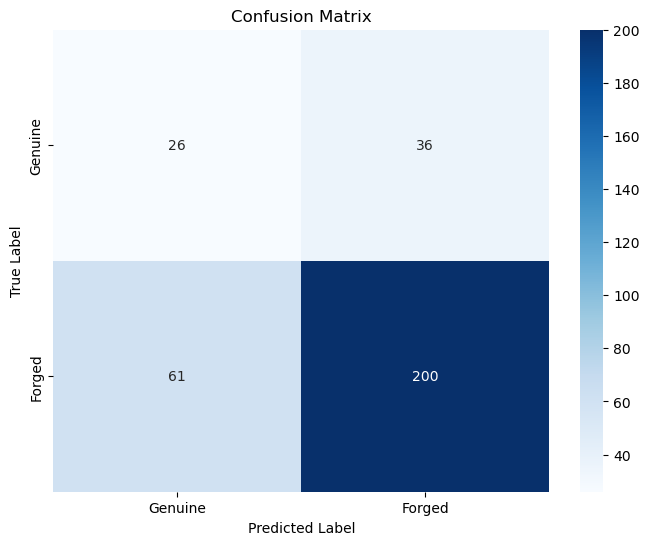

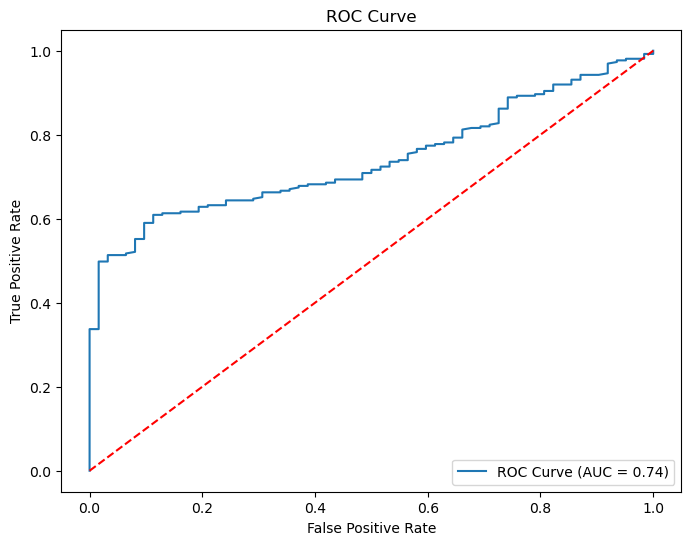

In [34]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm  # Import TQDM for progress bars

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset path
data_dir = r"C:\Users\abdul\Downloads\sign_data"  # Update the path to your signature dataset

# Data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Load the dataset
dataset = datasets.ImageFolder(data_dir, transform=data_transforms['train'])
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the model
model = models.resnet18(pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, 2)  # Assuming binary classification: genuine vs. forged
)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Early Stopping Callback
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

early_stopping = EarlyStopping()

# Training function with TQDM progress bar
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, early_stopping, num_epochs=25):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        train_progress = tqdm(train_loader, desc="Training", leave=False)

        for inputs, labels in train_progress:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        train_loss = running_loss / len(train_dataset)
        train_acc = running_corrects.double() / len(train_dataset)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        val_progress = tqdm(val_loader, desc="Validation", leave=False)

        with torch.no_grad():
            for inputs, labels in val_progress:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss /= len(val_dataset)
        val_acc = val_corrects.double() / len(val_dataset)

        scheduler.step(val_loss)
        early_stopping(val_loss)

        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc.item())
        history['val_acc'].append(val_acc.item())

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return history

# Evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred, y_scores = [], [], []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            probs = torch.softmax(outputs, dim=1)[:, 1]

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_scores.extend(probs.cpu().numpy())

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Genuine', 'Forged'], yticklabels=['Genuine', 'Forged'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

# Train and evaluate the model
history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, early_stopping)
evaluate_model(model, test_loader)


In [36]:
# Save the model's state dictionary
torch.save(model.state_dict(), 'best_model.pth')

# Optionally, save the optimizer state if you plan to resume training
torch.save(optimizer.state_dict(), 'optimizer.pth')
